In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import clip
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import pickle as pkl
import numpy as np 
import xgboost as xgb

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA available: False
CUDA version: None


In [41]:
X_train = pd.read_csv('../X_train.csv')
X_test = pd.read_csv('../X_test.csv')
y_train = pd.read_csv('../y_train.csv')
y_test = pd.read_csv('../y_test.csv')

In [42]:
class XgBoost(nn.Module):
    def __init__(self, n_features):
        super(XgBoost, self).__init__()
        self.xgb = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, objective='reg:squarederror')
    
    def forward(self, x):
        return self.xgb.predict(x)
        
    def fit(self, X, y):
        self.xgb.fit(X, y)
        

In [ ]:
import pandas as pd
import numpy as np

def generate_random_feature_combinations(X_train, X_test, num_features, random_state=None):
    """
    Randomly combines pairs of columns with random operations (including powers) to create new features,
    ensuring consistency between X_train and X_test.
    
    Parameters:
    - X_train: pd.DataFrame, the training dataset.
    - X_test: pd.DataFrame, the test dataset.
    - num_features: int, the number of new features to generate.
    - random_state: int, seed for reproducibility (default: None).
    
    Returns:
    - X_train_new: pd.DataFrame, training dataset with new features added.
    - X_test_new: pd.DataFrame, test dataset with new features added.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()
    columns = X_train.columns
    selected_pairs = []
    
    operations = ['*', '/']
    powers = ['^2', '^3', '^0.5', '^1.5'] 
    
    # Generate random column pairs and operations
    for _ in range(num_features):
        col1, col2 = np.random.choice(columns, 2, replace=False)
        operation = np.random.choice(operations + powers)
        selected_pairs.append((col1, col2, operation))
    
    # Apply the same pairs and operations to both X_train and X_test
    for col1, col2, operation in selected_pairs:
        new_feature_name = f"{col1}_{operation}_{col2}"
        

        if operation == '-':
            X_train_new[new_feature_name] = X_train_new[col1] - X_train_new[col2]
            X_test_new[new_feature_name] = X_test_new[col1] - X_test_new[col2]
        elif operation == '/':
            # Avoid division by zero using np.where
            X_train_new[new_feature_name] = np.where(X_train_new[col2] != 0, 
                                                      X_train_new[col1] / X_train_new[col2], 
                                                      np.nan)
            X_test_new[new_feature_name] = np.where(X_test_new[col2] != 0, 
                                                     X_test_new[col1] / X_test_new[col2], 
                                                     np.nan)
        elif operation == '^2':  # Square of the first column
            X_train_new[new_feature_name] = X_train_new[col1] ** 2
            X_test_new[new_feature_name] = X_test_new[col1] ** 2
        elif operation == '^3':  # Cube of the first column
            X_train_new[new_feature_name] = X_train_new[col1] ** 3
            X_test_new[new_feature_name] = X_test_new[col1] ** 3
        elif operation == '^0.5':  # Square root of the first column
            X_train_new[new_feature_name] = np.sqrt(X_train_new[col1])
            X_test_new[new_feature_name] = np.sqrt(X_test_new[col1])
    
    return X_train_new, X_test_new

# Example usage
X_train_new, X_test_new = generate_random_feature_combinations(X_train, X_test, num_features=1000, random_state=42)

print(X_train_new.head())
print(X_test_new.head())


/var/folders/t8/cq9vwh6d7dxfyjzswff4ys5m0000gn/T/ipykernel_85769/1611967144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_new[new_feature_name] = X_train_new[col1] ** 3
/var/folders/t8/cq9vwh6d7dxfyjzswff4ys5m0000gn/T/ipykernel_85769/1611967144.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_new[new_feature_name] = X_test_new[col1] ** 3
/var/folders/t8/cq9vwh6d7dxfyjzswff4ys5m0000gn/T/ipykernel_85769/1611967144.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

   photo_count  ispro  Animal  Electronics  Entertainment  Family  Fashion  \
0        279.0    0.0     0.0          0.0            0.0     0.0      0.0   
1       1213.0    1.0     0.0          0.0            1.0     0.0      0.0   
2       1592.0    0.0     0.0          0.0            0.0     0.0      1.0   
3       1013.0    0.0     0.0          0.0            0.0     0.0      1.0   
4       1776.0    1.0     0.0          0.0            0.0     0.0      0.0   

   Food  Holiday&Celebrations  Social&People  ...  knockout_^3_library  \
0   0.0                   0.0            0.0  ...                  0.0   
1   0.0                   0.0            0.0  ...                  0.0   
2   0.0                   0.0            0.0  ...                  0.0   
3   0.0                   0.0            0.0  ...                  0.0   
4   0.0                   0.0            0.0  ...                  0.0   

   Baseball_^3_lightsout  beam_^0.5_sea  snooze_^3_Summer  eyeliner_^0.5_mane  \
0    

/var/folders/t8/cq9vwh6d7dxfyjzswff4ys5m0000gn/T/ipykernel_85769/1611967144.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_new[new_feature_name] = np.sqrt(X_train_new[col1])
/var/folders/t8/cq9vwh6d7dxfyjzswff4ys5m0000gn/T/ipykernel_85769/1611967144.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_new[new_feature_name] = np.sqrt(X_test_new[col1])
/var/folders/t8/cq9vwh6d7dxfyjzswff4ys5m0000gn/T/ipykernel_85769/1611967144.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

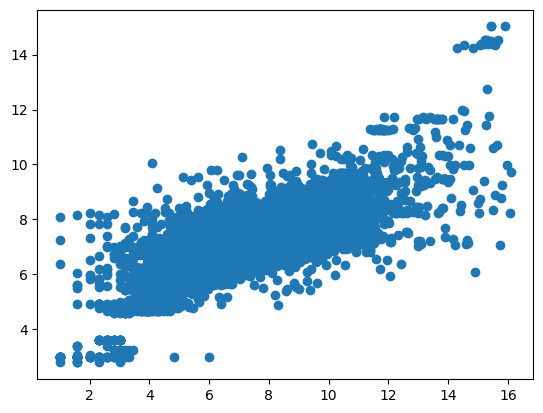

In [45]:
model = XgBoost(n_features=X_train.shape[1])
model.fit(X_train, y_train)
y_pred = model.forward(X_test)
plt.plot(y_test, y_pred, 'o')

